# Урок 6. Классификация текста. Анализ тональности текста

Взять ноутбук colab_text_classification_part1.ipynb который разбирали на занятии и добавить пункты которые мы пропустили 

1. Проверьте повысилось ли качество на стандартных подходах при лемматизации/и без неё
2. Удалите/(замените на тег) из текстов сущности(имена, локации, что-то ещё). Запустите классификатор и модельки на сеточках
3. Сделайте выводы

In [1]:
# !wget -O imdb.zip -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1vrQ5czMHoO3pEnmofFskymXMkq_u1dPc"
# !unzip imdb.zip
# !pip -q install eli5
# !pip -q install spacy
# !python -m spacy download en

# Классификация текстов

Начнём с самого простого - анализа тональности текста.

Будем классифицировать отзывы с IMDB на положительные/отрицательные.

Датасет взят с http://ai.stanford.edu/~amaas/data/sentiment/

In [4]:
import pandas as pd

train_df = pd.read_csv("train.tsv", delimiter="\t")
test_df = pd.read_csv("test.tsv", delimiter="\t")

print('Train size = {}'.format(len(train_df)))
print('Test size = {}'.format(len(test_df)))

Train size = 25000
Test size = 25000


Посмотрите глазами на тексты? Какие есть зацепки, как определить, что это за сентимент?

Самое простое, как всегда - найти ключевые слова.

### **Задание** Придумайте хорошие ключевые слова или фразы и наберите хотя бы 71% точности на тесте (и не забудьте посмотреть на код классификации!)

In [5]:
positive_words = 'love', 'great', 'best', 'wonderful', 'perfect', 'well', 'excellent', 'enjoyable', 'superb', 'biased', 'favorite', 'perfectly', 'amazing', 'skillful', 'classic', 'compelling', 'handsome', 'grateful' #@param {type:"raw"}
negative_words = 'worst', 'awful', '1/10', 'crap', 'terrible', 'idiot', 'ridiculous', 'problem', 'sorry', 'hardly', 'obnoxious', 'condescending', 'meaningless', 'flat', 'worse', 'puddle', 'weak', 'lacking', 'pretentious', 'unfortunately', 'disappoint', 'lame', 'phony' #@param {type:"raw"}

positives_count = test_df.review.apply(lambda text: sum(word in text for word in positive_words))
negatives_count = test_df.review.apply(lambda text: sum(word in text for word in negative_words))
is_positive = positives_count > negatives_count
correct_count = (is_positive == test_df.is_positive).values.sum()

accuracy = correct_count / len(test_df)

print('Test accuracy = {:.2%}'.format(accuracy))
# if accuracy > 0.71:
#     from IPython.display import Image, display
#     display(Image('https://s3.amazonaws.com/achgen360/t/rmmoZsub.png', width=500))

Test accuracy = 72.80%


**Задание** Кому-нибудь нравятся эти `<br /><br />`? Лично мне - нет. Напишите регулярку, которая будет их удалять

In [6]:
import re

pattern = re.compile('<br />')

print(train_df['review'].iloc[3])
print(pattern.subn(' ', train_df['review'].iloc[3])[0])

Spoilers ahead if you want to call them that...<br /><br />I would almost recommend this film just so people can truly see a 1/10. Where to begin, we'll start from the top...<br /><br />THE STORY: Don't believe the premise - the movie has nothing to do with abandoned cars, and people finially understanding what the mysterious happenings are. It's a draub, basic, go to cabin movie with no intensity or "effort".<br /><br />THE SCREENPLAY: I usually give credit to indie screenwriters, it's hard work when you are starting out...but this is crap. The story is flat - it leaves you emotionless the entire movie. The dialogue is extremely weak and predictable boasting lines of "Woah, you totally freaked me out" and "I was wondering if you'd uh...if you'd like to..uh, would you come to the cabin with me?". It makes me want to rip out all my hair, one strand at a time and feed it to myself.<br /><br />THE CHARACTERS: HOLY CRAP!!!! Some have described the characters as flat, I want to take it one 

Применим ее:

In [7]:
train_df['review'] = train_df['review'].apply(lambda text: pattern.subn(' ', text)[0])
test_df['review'] = test_df['review'].apply(lambda text: pattern.subn(' ', text)[0])

Пора переходить к машинке!

Как будем представлять текст? Проще всего - мешком слов.

Заведём большой-большой словарь - список всех слов в обучающей выборке. Тогда каждое предложение можно представить в виде вектора, в котором будет записано, сколько раз встретилось каждое из возможных слов:

![bow](https://raw.githubusercontent.com/DanAnastasyev/DeepNLP-Course/master/Week%2001/Images/BOW.png)

Простой и приятный способ сделать это - запихнуть тексты в `CountVectorizer`.

Он имеет такую сигнатуру:

```python
CountVectorizer(input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, token_pattern=r'(?u)\b\w\w+\b', ngram_range=(1, 1), analyzer='word', max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class ‘numpy.int64'>)
```

Для начала обратим внимание на параметры `lowercase=True` и `max_df=1.0, min_df=1, max_features=None` - они про то, что по умолчанию все слова будут приводиться к нижнему регистру и в словарь попадут все слова, встречавшиеся в текстах.

При желании можно было бы убрать слишком редкие или слишком частотные слова - пока не будем этого делать.

Посмотрим на простом примере, как он будет работать:

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

dummy_data = ['The movie was excellent',
              'the movie was awful']

dummy_matrix = vectorizer.fit_transform(dummy_data)

print(dummy_matrix.toarray())
print(vectorizer.get_feature_names())

[[0 1 1 1 1]
 [1 0 1 1 1]]
['awful', 'excellent', 'movie', 'the', 'was']


/Users/mac/miniconda3/envs/pytorch_p38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


*Как именно vectorizer определяет границы слов? Обратите внимание на параметр `token_pattern=r'(?u)\b\w\w+\b'` - как он будет работать?*

Запустим его на реальных данных:

In [9]:
vectorizer = CountVectorizer()
vectorizer.fit(train_df['review'].values)

CountVectorizer()

Посмотрим на слова, попавшие в словарь:

In [ ]:
vectorizer.get_feature_names()

Попробуем кого-нибудь таки сконвертировать

In [11]:
vectorizer.transform([train_df['review'].iloc[3]])

<1x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 206 stored elements in Compressed Sparse Row format>

То, что и хотели - вектор с bow (т.е. bag-of-words) представлением исходного текста.

И чем эта информация может помочь? Ну, всё тем же - какие-то слова носят положительный окрас, какие-то - отрицательный. Большинство вообще нейтральный, да.

![bow with weights](https://github.com/DanAnastasyev/DeepNLP-Course/raw/master/Week%2001/Images/BOW_weights.png)

Хочется, наверное, подобрать коэффициенты, которые будут определять уровень окраса, да? Подбирать нужно по обучающей выборке, а не как мы перед этим делали.

Например, для выборки
```
1   The movie was excellent
0   the movie was awful
```
легко подобрать коэффициенты на глазок: что-нибудь вроде `+1` для `excellent`,  `-1` для `awful` и по нулям всем остальным.

Построим линейную модель, которая станет этим заниматься. Она будет учиться строить разделяющую гиперплоскость в пространстве bow-векторов.

Проверим, как справится логистическая регрессия с нашей супер-выборкой из пары предложений

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

dummy_data = ['The movie was excellent',
              'the movie was awful']
dummy_labels = [1, 0]

vectorizer = CountVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(dummy_data, dummy_labels)

print(vectorizer.get_feature_names())
print(classifier.coef_)

['awful', 'excellent', 'movie', 'the', 'was']
[[-0.40104279  0.40104279  0.          0.          0.        ]]


/Users/mac/miniconda3/envs/pytorch_p38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Получилось что надо.

Запустим теперь её на реальных данных.

In [13]:
model.fit(train_df['review'], train_df['is_positive'])

/Users/mac/miniconda3/envs/pytorch_p38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', LogisticRegression())])

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def eval_model(model, test_df_X, test_df_Y):
    preds = model.predict(test_df_X)
    print('Test precision = {:.2%}'.format(precision_score(test_df_Y, preds)))
    print('Test recall = {:.2%}'.format(recall_score(test_df_Y, preds)))
    print('Test f1 = {:.2%}'.format(f1_score(test_df_Y, preds)))
    print('Test accuracy = {:.2%}'.format(accuracy_score(test_df_Y, preds)))
    
eval_model(model, test_df['review'], test_df['is_positive'])

Test precision = 87.09%
Test recall = 85.72%
Test f1 = 86.40%
Test accuracy = 86.51%


Прогресс!

Хочется как-то посмотреть, что заинтересовало классификатор. К счастью, сделать это совсем просто:

In [15]:
import eli5
eli5.show_weights(classifier, vec=vectorizer, top=40)

2022-11-01 12:50:48.331285: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/mac/miniconda3/envs/pytorch_p38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Weight?,Feature
+1.878,refreshing
+1.776,wonderfully
+1.705,funniest
+1.661,surprisingly
+1.638,rare
+1.431,superb
+1.407,excellent
+1.372,incredible
+1.342,perfect
+1.316,delightful


Посмотрим на конкретные примеры его работы:

In [16]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


In [17]:
print('Positive' if test_df['is_positive'].iloc[6] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[6], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Negative


/Users/mac/miniconda3/envs/pytorch_p38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Посмотрим на примеры неправильной классификации, наконец:

In [18]:
import numpy as np

preds = model.predict(test_df['review'])
incorrect_pred_index = np.random.choice(np.where(preds != test_df['is_positive'])[0])

eli5.show_prediction(classifier, test_df['review'].iloc[incorrect_pred_index],
                     vec=vectorizer, targets=['positive'], target_names=['negative', 'positive'])

/Users/mac/miniconda3/envs/pytorch_p38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Придумываем новые признаки

### Tf-idf

Сейчас мы на все слова смотрим с одинаковым весом - хотя какие-то из них более редкие, какие-то более частые, и эта частотность - полезная, вообще говоря, информация.

Самый простой способ добавить статистическую информацию о частотностях - сделать *tf-idf* взвешивание:

$$\text{tf-idf}(t, d) = \text{tf}(t, d) \times \text{idf}(t)$$

*tf* - term-frequency - частотность слова `t` в конкретном документе `d` (рецензии в нашем случае). Это ровно то, что мы уже считали.

*idf* - inverse document-frequency - коэффициент, который тем больше, чем в меньшем числе документов встречалось данное слово. Считается как-нибудь так:
$$\text{idf}(t) = \text{log}\frac{1 + n_d}{1 + n_{d(t)}} + 1$$
где $n_d$ - число всех документов, а $n_{d(t)}$ - число документов со словом `t`.

Использовать его просто - нужно заменить `CountVectorizer` на `TfidfVectorizer`.

**Задание** Попробуйте запустить `TfidfVectorizer`. Посмотрите на ошибки, которые он научился исправлять, и на ошибки, которые он начал делать - по сравнению с `CountVectorizer`.

In [19]:

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df['review'], test_df['is_positive'])

Test precision = 88.37%
Test recall = 88.17%
Test f1 = 88.27%
Test accuracy = 88.28%


### N-граммы слов

До сих пор мы смотрели на тексты как на мешок слов - но очевидно, что есть разница между `good movie` и `not good movie`.

Добавим информацию (хоть какую-то) о последовательностях слов - будем извлекать еще и биграммы слов.

В Vectorizer'ах для этого есть параметр `ngram_range=(n_1, n_2)` - он говорит, что нужны n_1-...n_2-граммы.

**Задание** Попробуйте увеличенный range и поинтерпретируйте полученный результат.

In [20]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df['review'], test_df['is_positive'])

Test precision = 88.01%
Test recall = 89.47%
Test f1 = 88.74%
Test accuracy = 88.64%


In [21]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df['review'], test_df['is_positive'])

Test precision = 87.01%
Test recall = 88.76%
Test f1 = 87.88%
Test accuracy = 87.76%


In [22]:
vectorizer = TfidfVectorizer(ngram_range=(2, 3))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df['review'], test_df['is_positive'])

Test precision = 85.62%
Test recall = 87.50%
Test f1 = 86.55%
Test accuracy = 86.40%


In [23]:
vectorizer = TfidfVectorizer(ngram_range=(1, 5))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df['review'], test_df['is_positive'])

Test precision = 85.80%
Test recall = 86.94%
Test f1 = 86.37%
Test accuracy = 86.28%


### ВЫВОД: с увеличением параметра ngram_range показатели метрик ухудшаются

### N-граммы символов

Символьные n-граммы дают простой способ выучить полезные корни и суффиксы, не связываясь с этой вашей лингвистикой - только статистика, только хардкор.

Например, слово `badass` мы можем представить в виде такой последовательности триграмм:

`##b #ba bad ada das ass ss# s##`

So interpretable, неправда ли?

Реализовать это дело всё так же просто - нужно поставить `analyzer='char'` в вашем любимом Vectorizer'е и выбрать размер `ngram_range`.

**Задание** Запилите классификатор на n-граммах символов и визуализируйте его.

In [24]:
vectorizer = TfidfVectorizer(ngram_range=(2, 6), max_features=20000, analyzer='char')
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df['review'], test_df['is_positive'])

/Users/mac/miniconda3/envs/pytorch_p38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test precision = 87.49%
Test recall = 88.34%
Test f1 = 87.91%
Test accuracy = 87.86%


In [25]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


/Users/mac/miniconda3/envs/pytorch_p38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Подключаем лингвистику

### Лемматизация и стемминг

Если присмотреться, можно найти формы одного слова с разной семантической окраской по мнению классификатора. Или нет?

**Задание** Найти формы слова с разной семантической окраской.

Поверя, что они есть, попробуем что-нибудь с этим сделать.

Например, лемматизируем - сведем к начальной форме все слова. Поможет в этом библиотека spacy.

In [26]:
import spacy
from spacy import displacy

# nlp = spacy.load('en', disable=['parser'])
nlp = spacy.load("en_core_web_sm")
# nlp = spacy.blank("en")

docs = [doc for doc in nlp.pipe(train_df.review.values[:50])]

In [27]:
for token in docs[0]:
    print(token.text, token.lemma_, token.ent_iob_, token.ent_type_)

Dreamgirls Dreamgirls B GPE
, , O 
despite despite O 
its its O 
fistful fistful O 
of of O 
Tony Tony B PERSON
wins win O 
in in O 
an an B DATE
incredibly incredibly I DATE
weak weak I DATE
year year I DATE
on on O 
Broadway Broadway B FAC
, , O 
has have O 
never never O 
been be O 
what what O 
one one O 
would would O 
call call O 
a a O 
jewel jewel O 
in in O 
the the O 
crown crown O 
of of O 
stage stage O 
musicals musical O 
. . O 
However however O 
, , O 
that that O 
is be O 
not not O 
to to O 
say say O 
that that O 
in in O 
the the O 
right right O 
cinematic cinematic O 
hands hand O 
it it O 
could could O 
not not O 
be be O 
fleshed flesh O 
out out O 
and and O 
polished polish O 
into into O 
something something O 
worthwhile worthwhile O 
on on O 
- - O 
screen screen O 
. . O 
Unfortunately unfortunately O 
, , O 
what what O 
transfers transfer O 
to to O 
the the O 
screen screen O 
is be O 
basically basically O 
a a O 
slavishly slavishly O 
faithful faith

**Задание** Сделайте классификатор на лемматизированных текстах.

Более простой способ нормализации слов - использовать стемминг. Он немного тупой, не учитывает контекст, но иногда оказывается даже эффективнее лемматизации - а, главное, быстрее.

По сути это просто набор правил, как обрезать слово, чтобы получить основу (stem):

In [28]:
train_df.head()

,is_positive,review
0,0,"Dreamgirls, despite its fistful of Tony wins i..."
1,0,This show comes up with interesting locations ...
2,1,I simply love this movie. I also love the Ramo...
3,0,Spoilers ahead if you want to call them that.....
4,1,My all-time favorite movie! I have seen many m...


**Лемматизируем данные и добавим к датасету.**

In [29]:
def lemmatize_data(text):
    doc = nlp(text)
    tokens_list = [token.lemma_ for token in doc]
    lemmatize_data = ' '.join(tokens_list)
    return lemmatize_data

In [30]:
# train_df['review_lemmatized'] = train_df['review'].apply(lemmatize_data)
# train_df.head()

In [31]:
train_df['review_lemmatized'] = train_df['review'].apply(lemmatize_data)
train_df.head()

,is_positive,review,review_lemmatized
0,0,"Dreamgirls, despite its fistful of Tony wins i...","Dreamgirls , despite its fistful of Tony win i..."
1,0,This show comes up with interesting locations ...,this show come up with interesting location as...
2,1,I simply love this movie. I also love the Ramo...,I simply love this movie . I also love the Ram...
3,0,Spoilers ahead if you want to call them that.....,spoiler ahead if you want to call they that .....
4,1,My all-time favorite movie! I have seen many m...,my all - time favorite movie ! I have see many...


In [32]:
test_df['review_lemmatized'] = test_df['review'].apply(lemmatize_data)
test_df.head()

,is_positive,review,review_lemmatized
0,0,A formulaic story with all the tired cliches. ...,a formulaic story with all the tired cliche . ...
1,1,This is both an entertaining and a touching ve...,this be both an entertaining and a touching ve...
2,0,Corey Haim is never going to be known as one o...,Corey Haim be never go to be know as one of th...
3,1,If you believe that any given war movie can ma...,if you believe that any give war movie can mak...
4,1,Carla Gugino literally melts the screen in thi...,Carla Gugino literally melt the screen in this...


**Обучим классификатор на новых данных и выведем метрики.**

In [35]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review_lemmatized'], train_df['is_positive'])

eval_model(model, test_df['review_lemmatized'], test_df['is_positive'])

Test precision = 88.13%
Test recall = 89.56%
Test f1 = 88.84%
Test accuracy = 88.75%


**Показатели метрики немного подросли по сравнению с показателями предыдущей самой лучшей модели (данные в строке ниже), но не существенно. **

Test precision = 88.01%
Test recall = 89.47%
Test f1 = 88.74%
Test accuracy = 88.64%

**Попробуем почистить данные и удалить из них лишний мусор и шум.**

Уберем пунктуацию и стоп-слова.

In [36]:
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation

In [37]:
noise = list(STOP_WORDS) + list(punctuation)
print(noise)

['upon', 'down', '’d', 'ca', 'however', 'back', 'more', 'his', 'under', 'toward', '’m', 'three', 'besides', 'often', "n't", 'give', 'one', 'that', 'per', '’s', 'can', 'another', 'serious', 'same', "'m", 'formerly', 'afterwards', 'hence', 'amongst', 'an', 'eight', 'towards', 'then', 'hereby', 'becoming', 'hereupon', 'not', 'neither', 'whoever', 'wherein', 'get', 'thereupon', 'nevertheless', 'every', 'via', '‘re', 'less', 'moreover', '‘d', 'show', 'our', 'third', 'latter', 'we', 'somewhere', 'which', 'well', 'keep', '’ll', 'n‘t', 'see', 'elsewhere', 'really', 'using', 'cannot', 'during', 'i', 'others', 'beforehand', 'anyone', 'several', 'everything', 'go', 'between', 'anything', 'mine', "'d", 'side', 'so', 'off', 'is', 'put', 'being', 'too', 'name', 'those', 'six', 'himself', 'across', 'move', 'four', 'anywhere', 'but', 'last', 'become', 'mostly', 'otherwise', 'ours', 'rather', 'been', 'these', 'ever', 'why', 'n’t', 're', 'where', 'you', 'before', 'after', 'some', 'would', 'yourselves', 

In [38]:
def lemmatize_data_clean(text):
    doc = nlp(text)
    tokens_list = [token.lemma_ for token in doc]
    tokens_list_clean = [token for token in tokens_list if not token in noise]
    lemmatize_data_clean = ' '.join(tokens_list_clean)
    return lemmatize_data_clean

In [39]:
train_df['review_lemmatized_clean'] = train_df['review'].apply(lemmatize_data_clean)
train_df.head()

,is_positive,review,review_lemmatized,review_lemmatized_clean
0,0,"Dreamgirls, despite its fistful of Tony wins i...","Dreamgirls , despite its fistful of Tony win i...",Dreamgirls despite fistful Tony win incredibly...
1,0,This show comes up with interesting locations ...,this show come up with interesting location as...,come interesting location fast travel channel ...
2,1,I simply love this movie. I also love the Ramo...,I simply love this movie . I also love the Ram...,I simply love movie I love Ramones I sorta bia...
3,0,Spoilers ahead if you want to call them that.....,spoiler ahead if you want to call they that .....,spoiler ahead want ... I recommend film peop...
4,1,My all-time favorite movie! I have seen many m...,my all - time favorite movie ! I have see many...,time favorite movie I movie beat excelent acti...


In [40]:
test_df['review_lemmatized_clean'] = test_df['review'].apply(lemmatize_data_clean)
test_df.head()

,is_positive,review,review_lemmatized,review_lemmatized_clean
0,0,A formulaic story with all the tired cliches. ...,a formulaic story with all the tired cliche . ...,formulaic story tired cliche I shock horrible ...
1,1,This is both an entertaining and a touching ve...,this be both an entertaining and a touching ve...,entertaining touching version classic tale int...
2,0,Corey Haim is never going to be known as one o...,Corey Haim be never go to be know as one of th...,Corey Haim know great actor time movie like li...
3,1,If you believe that any given war movie can ma...,if you believe that any give war movie can mak...,believe war movie feel war need Letyat zhuravl...
4,1,Carla Gugino literally melts the screen in thi...,Carla Gugino literally melt the screen in this...,Carla Gugino literally melt screen crime caper...


In [53]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review_lemmatized_clean'], train_df['is_positive'])

eval_model(model, test_df['review_lemmatized_clean'], test_df['is_positive'])

Test precision = 86.30%
Test recall = 87.97%
Test f1 = 87.13%
Test accuracy = 87.00%


**Без пунктуации и стоп-слов метрика стала чуть хуже. Значит их наличие было полезным.**

In [41]:
from nltk import PorterStemmer

stemmer = PorterStemmer()

print(stemmer.stem('become'))
print(stemmer.stem('becomes'))
print(stemmer.stem('became'))

becom
becom
becam


**Задание** Попробуйте вместо лемм классифицировать основы.

In [54]:
def stem_data(text):
    list_word = text.split()
    list_stem = [stemmer.stem(word) for word in list_word]
    stem_text = ' '.join(list_stem)
    return stem_text

In [55]:
train_df['review_stem'] = train_df['review'].apply(stem_data)
train_df.head()

,is_positive,review,review_lemmatized,review_lemmatized_clean,review_stem
0,0,"Dreamgirls, despite its fistful of Tony wins i...","Dreamgirls , despite its fistful of Tony win i...",Dreamgirls despite fistful Tony win incredibly...,"dreamgirls, despit it fist of toni win in an i..."
1,0,This show comes up with interesting locations ...,this show come up with interesting location as...,come interesting location fast travel channel ...,thi show come up with interest locat as fast a...
2,1,I simply love this movie. I also love the Ramo...,I simply love this movie . I also love the Ram...,I simply love movie I love Ramones I sorta bia...,I simpli love thi movie. I also love the ramon...
3,0,Spoilers ahead if you want to call them that.....,spoiler ahead if you want to call they that .....,spoiler ahead want ... I recommend film peop...,spoiler ahead if you want to call them that......
4,1,My all-time favorite movie! I have seen many m...,my all - time favorite movie ! I have see many...,time favorite movie I movie beat excelent acti...,My all-tim favorit movie! I have seen mani mov...


In [56]:
test_df['review_stem'] = test_df['review'].apply(stem_data)
test_df.head()

,is_positive,review,review_lemmatized,review_lemmatized_clean,review_stem
0,0,A formulaic story with all the tired cliches. ...,a formulaic story with all the tired cliche . ...,formulaic story tired cliche I shock horrible ...,A formula stori with all the tire cliches. I w...
1,1,This is both an entertaining and a touching ve...,this be both an entertaining and a touching ve...,entertaining touching version classic tale int...,thi is both an entertain and a touch version o...
2,0,Corey Haim is never going to be known as one o...,Corey Haim be never go to be know as one of th...,Corey Haim know great actor time movie like li...,corey haim is never go to be known as one of t...
3,1,If you believe that any given war movie can ma...,if you believe that any give war movie can mak...,believe war movie feel war need Letyat zhuravl...,If you believ that ani given war movi can make...
4,1,Carla Gugino literally melts the screen in thi...,Carla Gugino literally melt the screen in this...,Carla Gugino literally melt screen crime caper...,carla gugino liter melt the screen in thi crim...


In [57]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review_stem'], train_df['is_positive'])

eval_model(model, test_df['review_stem'], test_df['is_positive'])

Test precision = 87.70%
Test recall = 89.06%
Test f1 = 88.37%
Test accuracy = 88.28%


**Метрики с лемматизацией несколько выше (test accuracy = 88.75%).**

### NER

В текстах рецензий очень много именованных сущностей. Вот, например:

In [42]:
displacy.render(docs[0], style='ent', jupyter=True)

Вообще говоря, почему вдруг какой-нибудь Депп должен нести семантическую окраску? Однако оказывается, что классификатор выучивает, что какие-то имена чаще в положительных рецензиях - или наоборот. Это похоже на переобучение - почему бы не попробовать вырезать сущности?

**Задание** Удалите из текстов какие-то из сущностей, пользуясь координатами из запикленных файлов. Описание сущностей можно посмотреть [здесь](https://spacy.io/api/annotation#named-entities). Запустите классификатор.

In [58]:
def delete_entity(text):
    doc = nlp(text)
    tokens_lemm_list = [token.text for token in doc if token.ent_type_ not in ['ORG', 'TIME', 'MONEY']]
    del_entity = ' '.join(tokens_lemm_list)
    return del_entity

In [59]:
train_df['review_del_entity'] = train_df['review_lemmatized'].apply(delete_entity)
train_df.head()

,is_positive,review,review_lemmatized,review_lemmatized_clean,review_stem,review_del_entity
0,0,"Dreamgirls, despite its fistful of Tony wins i...","Dreamgirls , despite its fistful of Tony win i...",Dreamgirls despite fistful Tony win incredibly...,"dreamgirls, despit it fist of toni win in an i...","Dreamgirls , despite its fistful of Tony win i..."
1,0,This show comes up with interesting locations ...,this show come up with interesting location as...,come interesting location fast travel channel ...,thi show come up with interest locat as fast a...,this show come up with interesting location as...
2,1,I simply love this movie. I also love the Ramo...,I simply love this movie . I also love the Ram...,I simply love movie I love Ramones I sorta bia...,I simpli love thi movie. I also love the ramon...,I simply love this movie . I also love the Ram...
3,0,Spoilers ahead if you want to call them that.....,spoiler ahead if you want to call they that .....,spoiler ahead want ... I recommend film peop...,spoiler ahead if you want to call them that......,spoiler ahead if you want to call they that .....
4,1,My all-time favorite movie! I have seen many m...,my all - time favorite movie ! I have see many...,time favorite movie I movie beat excelent acti...,My all-tim favorit movie! I have seen mani mov...,my all - time favorite movie ! I have see many...


In [60]:
test_df['review_del_entity'] = test_df['review_lemmatized'].apply(delete_entity)
test_df.head()

,is_positive,review,review_lemmatized,review_lemmatized_clean,review_stem,review_del_entity
0,0,A formulaic story with all the tired cliches. ...,a formulaic story with all the tired cliche . ...,formulaic story tired cliche I shock horrible ...,A formula stori with all the tire cliches. I w...,a formulaic story with all the tired cliche . ...
1,1,This is both an entertaining and a touching ve...,this be both an entertaining and a touching ve...,entertaining touching version classic tale int...,thi is both an entertain and a touch version o...,this be both an entertaining and a touching ve...
2,0,Corey Haim is never going to be known as one o...,Corey Haim be never go to be know as one of th...,Corey Haim know great actor time movie like li...,corey haim is never go to be known as one of t...,Corey Haim be never go to be know as one of th...
3,1,If you believe that any given war movie can ma...,if you believe that any give war movie can mak...,believe war movie feel war need Letyat zhuravl...,If you believ that ani given war movi can make...,if you believe that any give war movie can mak...
4,1,Carla Gugino literally melts the screen in thi...,Carla Gugino literally melt the screen in this...,Carla Gugino literally melt screen crime caper...,carla gugino liter melt the screen in thi crim...,Carla Gugino literally melt the screen in this...


In [61]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review_del_entity'], train_df['is_positive'])

eval_model(model, test_df['review_del_entity'], test_df['is_positive'])

Test precision = 87.99%
Test recall = 89.64%
Test f1 = 88.81%
Test accuracy = 88.70%


**Удаление сущностей с тегами 'ORG', 'TIME', 'MONEY' не оказало сколь нибудь заметного влияния на метрики. Показатель accuracy ухудшился на 0.05%. Полагаю, необходимо провести больше экспериментов, чтобы определить наличие или отстутствие каких сущностей влияет положительно на результат.** 

## Включаем дип лёрнинг

Мы тут пришли deep learning'ом заниматься, а делаем почему-то модель на логистической регрессии. Как так?

Попробуем запустить относительно стандартную модель для классификации текстов - сверточная сеть поверх словных эмбеддингов.

Разбираться, что это за зверь, будем на следующих занятиях, а пока будем просто им пользоваться :)

Каждое предложение нужно представлять набором слов - и сразу же начинаются проблемы. Во-первых, как ограничить длину предложения?

Прикинем по гистограмме, какая длина нам подходит:

In [43]:
train_df['review']

0        Dreamgirls, despite its fistful of Tony wins i...
1        This show comes up with interesting locations ...
2        I simply love this movie. I also love the Ramo...
3        Spoilers ahead if you want to call them that.....
4        My all-time favorite movie! I have seen many m...
                               ...                        
24995    I am a big fan of the movie, but not for the u...
24996    I'm not going to bother with a plot synopsis s...
24997    This movie . . . I don't know. Why they would ...
24998    Saw this film on DVD yesterday and was gob-sma...
24999    This was a disappointment - none of the nuance...
Name: review, Length: 25000, dtype: object

<BarContainer object of 231 artists>

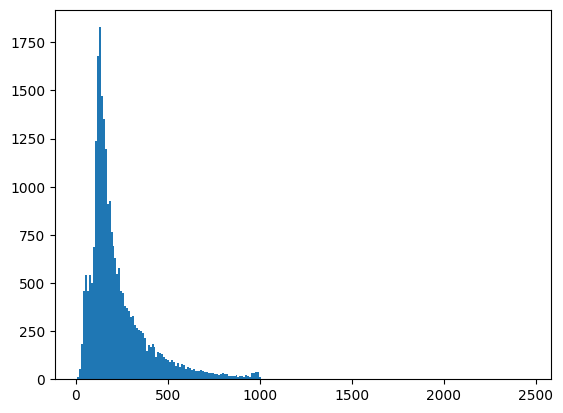

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt

_, _, hist = plt.hist(train_df.review.apply(lambda text: len(text.split())), bins='auto')
hist

Кроме этого, нужно перенумеровать как-то слова.

In [62]:
from collections import Counter

words_counter = Counter((word for text in train_df.review for word in text.lower().split()))

word2idx = {
    '': 0,
    '': 1
}
for word, count in words_counter.most_common():
    if count < 10:
        break
        
    word2idx[word] = len(word2idx)
    
print('Words count', len(word2idx))

Words count 26782


**Задание** Сконвертируйте данные

In [46]:
def convert(texts, word2idx, max_text_len):
    data = np.zeros((len(texts), max_text_len), dtype=np.int)
    
    for inx, text in enumerate(texts):
        result = []
        for word in text.split():
            if word in word2idx:
                result.append(word2idx[word])
        padding = [0]*(max_text_len - len(result))
        data[inx] = np.array(padding + result[-max_text_len:], dtype=np.int)
    return data

X_train = convert(train_df.review, word2idx, 1000)
X_test = convert(test_df.review, word2idx, 1000)

/var/folders/r4/tj59nbc57_3bl6zqxrkxfk140000gn/T/ipykernel_2234/1263189772.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = np.zeros((len(texts), max_text_len), dtype=np.int)
/var/folders/r4/tj59nbc57_3bl6zqxrkxfk140000gn/T/ipykernel_2234/1263189772.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish

Поставим учиться модельку на keras.

*Напоминание*: на keras, чтобы обучить модель, нужно
1. Определить модель, например:
```python 
model = Sequential()
model.add(Dense(1, activation='sigmoid', input_dim=NUM_WORDS))
```
2. Задать функцию потерь и оптимизатор:
```python
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
```

3. Запустить обучение:
```python
model.fit(X_train, y_train, 
          batch_size=32,
          epochs=3,
          validation_data=(X_test, y_test))
```

В NLP чаще всего ставятся задачи классификации, поэтому нужно запомнить такие функции потерь:

*   **categorical_crossentropy** - для многоклассовой классификации, в качестве меток должны передаваться one-hot-encoding вектора
*   **sparse_categorical_crossentropy** - аналогично предыдущему, но в качестве меток нужно передавать просто индексы соответствующих классов
*   **binary_crossentropy** - для бинарной классификации


В качестве оптимизатора обычно используют `sgd` или `adam`.


In [ ]:
# !pip install tensorflow

In [48]:
import tensorflow as tf
tf.__version__

'2.10.0'

In [49]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPooling1D, Dropout

In [65]:
model_nn = Sequential([
    Embedding(input_dim=len(word2idx), output_dim=64, input_shape=(X_train.shape[1],)),
    GlobalMaxPooling1D(),
    Dense(units=10, activation='relu'),
    Dense(units=10, activation='relu'),

    Dense(units=1, activation='sigmoid')
])

model_nn.summary()
model_nn.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 64)          1714048   
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,714,819
Trainable params: 1,714,819
Non-trainable params: 0
____________________________________________

In [69]:
class LearningRateReducerCb(tf.keras.callbacks.Callback):

  def on_epoch_end(self, epoch, logs={}):
    old_lr = self.model.optimizer.lr.read_value()
    new_lr = old_lr * 0.99
    print("\nEpoch: {}. Reducing Learning Rate from {} to {}".format(epoch, old_lr, new_lr))
    self.model.optimizer.lr.assign(new_lr)

In [70]:
model_nn.fit(X_train, train_df.is_positive, batch_size=128, callbacks=[LearningRateReducerCb()], epochs=10, 
          validation_data=(X_test, test_df.is_positive))

Epoch 1/10
195/196 [============================>.] - ETA: 0s - loss: 0.0014 - accuracy: 0.9997
Epoch: 0. Reducing Learning Rate from 0.0010000000474974513 to 0.0009900000877678394
196/196 [==============================] - 13s 65ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.5037 - val_accuracy: 0.8704
Epoch 2/10
195/196 [============================>.] - ETA: 0s - loss: 9.5954e-04 - accuracy: 0.9999
Epoch: 1. Reducing Learning Rate from 0.0009900000877678394 to 0.000980100128799677
196/196 [==============================] - 13s 64ms/step - loss: 9.5909e-04 - accuracy: 0.9999 - val_loss: 0.5178 - val_accuracy: 0.8704
Epoch 3/10
195/196 [============================>.] - ETA: 0s - loss: 8.8129e-04 - accuracy: 0.9998
Epoch: 2. Reducing Learning Rate from 0.000980100128799677 to 0.0009702991228550673
196/196 [==============================] - 12s 62ms/step - loss: 8.8109e-04 - accuracy: 0.9998 - val_loss: 0.5361 - val_accuracy: 0.8695
Epoch 4/10
195/196 [========================

**Задание** Подсчитайте качество модели на тесте

In [71]:
loss, accuracy = model_nn.evaluate(X_test, test_df.is_positive)
print("Test loss {:.4f}, accuracy {:.2f}%".format(loss, accuracy * 100))

782/782 [==============================] - 3s 4ms/step - loss: 0.6001 - accuracy: 0.8676
Test loss 0.6001, accuracy 86.76%
